In [ ]:
!unzip /content/preprocessed.zip -d /content/preprocessed

Streaming output truncated to the last 5000 lines.
  inflating: /content/preprocessed/preprocessed/8827.jpg  
  inflating: /content/preprocessed/preprocessed/88272.jpg  
  inflating: /content/preprocessed/preprocessed/88273.jpg  
  inflating: /content/preprocessed/preprocessed/88274.jpg  
  inflating: /content/preprocessed/preprocessed/88275.jpg  
  inflating: /content/preprocessed/preprocessed/8828.jpg  
  inflating: /content/preprocessed/preprocessed/8829.jpg  
  inflating: /content/preprocessed/preprocessed/88291.jpg  
  inflating: /content/preprocessed/preprocessed/88292.jpg  
  inflating: /content/preprocessed/preprocessed/88293.jpg  
  inflating: /content/preprocessed/preprocessed/88294.jpg  
  inflating: /content/preprocessed/preprocessed/883.jpg  
  inflating: /content/preprocessed/preprocessed/8830.jpg  
  inflating: /content/preprocessed/preprocessed/88301.jpg  
  inflating: /content/preprocessed/preprocessed/88306.jpg  
  inflating: /content/preprocessed/preprocessed/88307.j

In [ ]:
len(os.listdir('/content/preprocessed/preprocessed'))

90000

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
IMG_DIR = "/content/preprocessed/preprocessed"

# Load CSV and encode labels
df = pd.read_csv("/content/merged_classes.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

# Limit the dataset to 200 samples per class
df_limited = df.groupby('label').apply(lambda x: x.head(9000)).reset_index(drop=True)

# Train/Validation split
train_df, val_df = train_test_split(df_limited, test_size=0.1, stratify=df_limited['label'], random_state=42)

# Custom Data Generator
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASSES, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        labels = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, f"{row['Asset_id']}.jpg")
            try:
                img = load_img(img_path, target_size=(self.img_size, self.img_size))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(row['label'])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        return np.array(images), tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

# Create generators
train_gen = ImageDataGenerator(train_df, IMG_DIR)
val_gen = ImageDataGenerator(val_df, IMG_DIR, shuffle=False)

# Define the improved model
model = Sequential([
    SeparableConv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    SeparableConv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    SeparableConv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    # Use GlobalAveragePooling instead of Flatten for better generalization
    GlobalAveragePooling2D(),

    Dropout(0.5),  # Increased dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Learning Rate Scheduler and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

# Save the model
model.save("improved_separable_cnn_model.h5")


<ipython-input-22-c3918c02df9f>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df.groupby('label').apply(lambda x: x.head(9000)).reset_index(drop=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_50             │ (None, 222, 222, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_51             │ (None, 109, 109, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_52             │ (None, 52, 52, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,149 (117.77 KB)

 Trainable params: 29,701 (116.02 KB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 144s 53ms/step - accuracy: 0.2548 - loss: 2.0033 - val_accuracy: 0.3140 - val_loss: 1.9604 - learning_rate: 0.0010
Epoch 2/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 132s 52ms/step - accuracy: 0.4335 - loss: 1.4929 - val_accuracy: 0.5220 - val_loss: 1.1956 - learning_rate: 0.0010
Epoch 3/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.4901 - loss: 1.3091 - val_accuracy: 0.4012 - val_loss: 1.6092 - learning_rate: 0.0010
Epoch 4/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 132s 52ms/step - accuracy: 0.5164 - loss: 1.2366 - val_accuracy: 0.5083 - val_loss: 1.2470 - learning_rate: 0.0010
Epoch 5/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 129s 51ms/step - accuracy: 0.5373 - loss: 1.1753 - val_accuracy: 0.5749 - val_loss: 1.0731 - learning_rate: 0.0010
Epoch 6/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 123s 49ms/step - accuracy: 0.5476 - loss: 1.1513 - val_accuracy: 0.5756 - val_loss: 1.0300 - learning_rate: 0.0010
Epoch 7/20
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step -

KeyboardInterrupt: 

# Main Model in this block

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D, Input
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
IMG_DIR = "/content/preprocessed/preprocessed"

# Load CSV and encode labels
df = pd.read_csv("/content/merged_classes.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

# Limit the dataset to 9000 samples per class
df_limited = df.groupby('label', group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)

# Train/Validation split
train_df, val_df = train_test_split(df_limited, test_size=0.1, stratify=df_limited['label'], random_state=42)

# Custom Data Generator
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASSES, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        labels = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, f"{row['Asset_id']}.jpg")
            try:
                img = load_img(img_path, target_size=(self.img_size, self.img_size))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(row['label'])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        return np.array(images), tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

# Create generators
train_gen = ImageDataGenerator(train_df, IMG_DIR)
val_gen = ImageDataGenerator(val_df, IMG_DIR, shuffle=False)

# Build the model
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    SeparableConv2D(64, (3, 3), activation='relu',
                    depthwise_regularizer=l2(1e-4),
                    pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    SeparableConv2D(64, (3, 3), activation='relu',
                    depthwise_regularizer=l2(1e-4),
                    pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    SeparableConv2D(128, (3, 3), activation='relu',
                    depthwise_regularizer=l2(1e-4),
                    pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    SeparableConv2D(128, (3, 3), activation='relu',
                    depthwise_regularizer=l2(1e-4),
                    pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    SeparableConv2D(256, (3, 3), activation='relu',
                    depthwise_regularizer=l2(1e-4),
                    pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    SeparableConv2D(256, (3, 3), activation='relu',
                    depthwise_regularizer=l2(1e-4),
                    pointwise_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Learning Rate Scheduler and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[lr_scheduler, early_stopping]
)

# Save the model
model.save("separable_cnn_improved_75acc.h5")


<ipython-input-3-0b3c2ae7944c>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df.groupby('label', group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_1              │ (None, 222, 222, 64)   │           283 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 220, 220, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 108, 108, 128)  │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 106, 106, 128)  │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 51, 51, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 49, 49, 256)    │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 205,797 (803.89 KB)

 Trainable params: 204,005 (796.89 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2532/2532 ━━━━━━━━━━━━━━━━━━━━ 529s 199ms/step - accuracy: 0.3349 - loss: 1.8602 - val_accuracy: 0.4630 - val_loss: 1.4362 - learning_rate: 0.0010
Epoch 2/10
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 533s 195ms/step - accuracy: 0.5989 - loss: 1.1300 - val_accuracy: 0.6224 - val_loss: 1.0344 - learning_rate: 0.0010
Epoch 3/10
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 495s 196ms/step - accuracy: 0.6589 - loss: 0.9774 - val_accuracy: 0.6883 - val_loss: 0.8906 - learning_rate: 0.0010
Epoch 4/10
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 493s 195ms/step - accuracy: 0.6813 - loss: 0.9183 - val_accuracy: 0.6479 - val_loss: 0.9725 - learning_rate: 0.0010
Epoch 5/10
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 495s 195ms/step - accuracy: 0.6980 - loss: 0.8778 - val_accuracy: 0.6508 - val_loss: 1.0339 - learning_rate: 0.0010
Epoch 6/10
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 497s 196ms/step - accuracy: 0.7091 - loss: 0.8484 - val_accuracy: 0.7110 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 7/10
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 491s 194ms/step - acc

In [ ]:
model.save("separable_cnn_improved_75acc.keras")

# Ignore next block's 5 epochs since they were reducing accuracy had to stop it to prevent overfittting

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
IMG_DIR = "/content/preprocessed/preprocessed"

# Load CSV and encode labels
df = pd.read_csv("/content/merged_classes.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

# Limit the dataset to 9000 samples per class
df_limited = df.groupby('label', group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)

# Train/Validation split
train_df, val_df = train_test_split(df_limited, test_size=0.1, stratify=df_limited['label'], random_state=42)

# Custom Data Generator
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASSES, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        labels = []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, f"{row['Asset_id']}.jpg")
            try:
                img = load_img(img_path, target_size=(self.img_size, self.img_size))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(row['label'])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        return np.array(images), tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

# Create generators
train_gen = ImageDataGenerator(train_df, IMG_DIR)
val_gen = ImageDataGenerator(val_df, IMG_DIR, shuffle=False)

# Load the previously saved model
model = load_model("/content/separable_cnn_improved_75acc.keras")

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Continue training for 5 more epochs
history_fine_tune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[lr_scheduler, early_stopping]
)

# Save the updated model in the new Keras format
model.save("separable_cnn_finetuned.keras")


<ipython-input-6-929a69eca154>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df.groupby('label', group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2532/2532 ━━━━━━━━━━━━━━━━━━━━ 503s 195ms/step - accuracy: 0.7406 - loss: 0.7879 - val_accuracy: 0.7419 - val_loss: 0.7599 - learning_rate: 0.0010
Epoch 2/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 480s 190ms/step - accuracy: 0.7338 - loss: 0.8074 - val_accuracy: 0.7211 - val_loss: 0.8342 - learning_rate: 0.0010
Epoch 3/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 479s 189ms/step - accuracy: 0.7303 - loss: 0.8322 - val_accuracy: 0.7312 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 4/5
1485/2532 ━━━━━━━━━━━━━━━━━━━━ 3:14 186ms/step - accuracy: 0.7298 - loss: 0.8366

# Testing On 1000 images to evaluate the model's performance and accuracy.

<ipython-input-2-a1516499a459>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df.groupby('label', group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)


Using 1000 images for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
Validating: 100%|██████████| 10/10 [06:59<00:00, 41.96s/it]


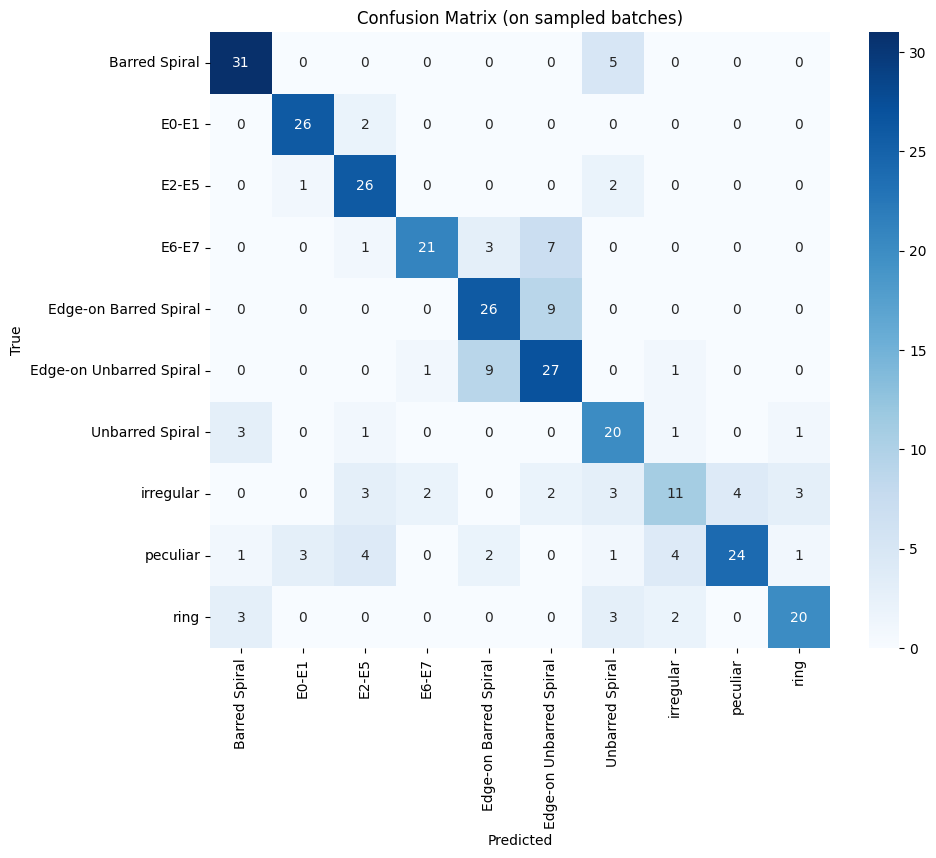

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
IMG_DIR = "/content/preprocessed/preprocessed"

# Load labels
df = pd.read_csv("/content/merged_classes.csv")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

# Limit and split
df_limited = df.groupby('label', group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)
_, val_df = train_test_split(df_limited, test_size=0.1, stratify=df_limited['label'], random_state=42)

# Sample only 1000 images
val_df_sampled = val_df.sample(n=1000, random_state=42).reset_index(drop=True)
print(f"Using {len(val_df_sampled)} images for validation.")

# Minimal custom generator
class ImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=BATCH_SIZE):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size : (idx + 1) * self.batch_size]
        images, labels = [], []

        for _, row in batch_df.iterrows():
            path = os.path.join(self.img_dir, f"{row['Asset_id']}.jpg")
            try:
                img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
                images.append(img_to_array(img) / 255.0)
                labels.append(row['label'])
            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue

        return (
            np.array(images),
            np.array(labels)
        ) if images else (np.empty((0, IMG_SIZE, IMG_SIZE, 3)), np.array([]))

# Load model
model = tf.keras.models.load_model("/content/separable_cnn_improved_75acc.keras")

# Generator
val_gen = ImageDataGenerator(val_df_sampled, IMG_DIR)

# Predict with progress bar and batch limiter
max_batches = 10  # You can increase this to process more batches
y_true, y_pred = [], []

for i, (x_batch, y_batch) in enumerate(tqdm(val_gen, desc="Validating", total=max_batches)):
    if i >= max_batches:
        break
    if len(x_batch) == 0:
        continue
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch)
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
if y_true and y_pred:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (on sampled batches)")
    plt.show()
else:
    print("No predictions were made. Try increasing max_batches or check image paths.")


c:\Users\grace\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



📊 Evaluation Metrics (100 images):
Accuracy : 0.7560
Precision: 0.7625
Recall   : 0.7560
F1 Score : 0.7529

📝 Classification Report:
                         precision    recall  f1-score   support

          Barred Spiral       0.81      0.90      0.85        48
                  E0-E1       0.80      1.00      0.89        51
                  E2-E5       0.87      0.96      0.91        50
                  E6-E7       0.96      0.81      0.88        57
  Edge-on Barred Spiral       0.56      0.63      0.59        46
Edge-on Unbarred Spiral       0.60      0.65      0.62        57
        Unbarred Spiral       0.67      0.81      0.73        37
              irregular       0.73      0.52      0.61        52
               peculiar       0.71      0.57      0.63        51
                   ring       0.88      0.75      0.81        51

               accuracy                           0.76       500
              macro avg       0.76      0.76      0.75       500
           weighted

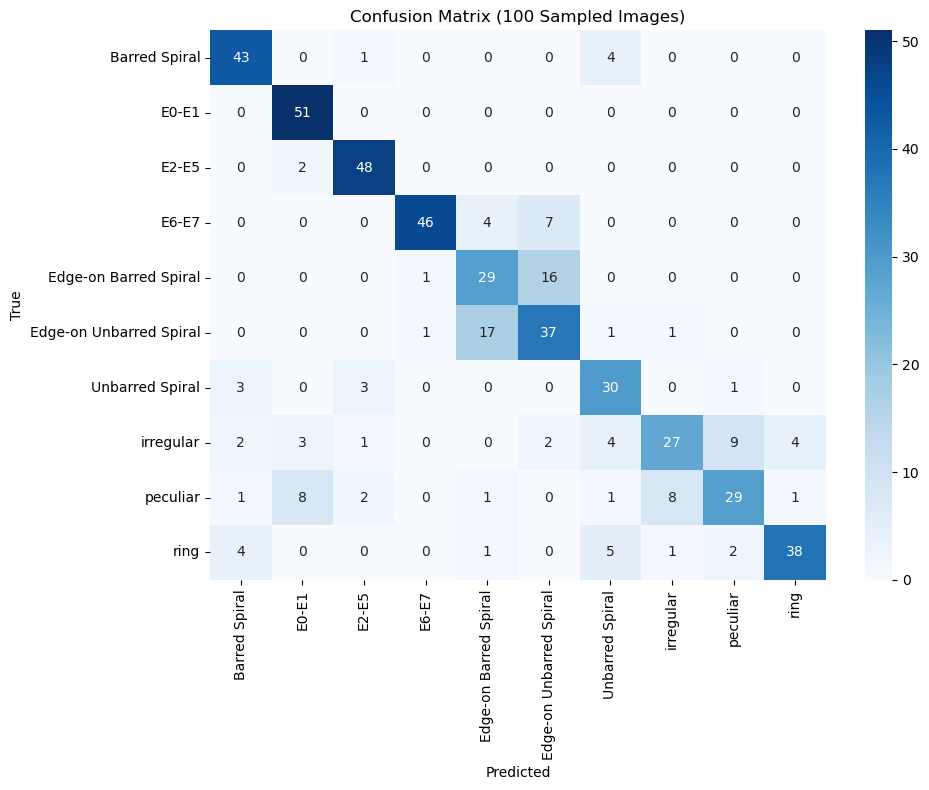

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

# === CONFIG ===
IMG_SIZE = 224
IMG_DIR = "preprocessed"
MODEL_PATH = "separable_cnn_improved_75acc.keras"
LABELS_CSV = "merged_classes.csv"

# === 1. Load labels and sample 100 ===
df = pd.read_csv(LABELS_CSV)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["class"])
df_limited = df.groupby("label", group_keys=False).apply(lambda x: x.head(9000)).reset_index(drop=True)
_, val_df = train_test_split(df_limited, test_size=0.1, stratify=df_limited['label'], random_state=2)
val_sample = val_df.sample(n=500, random_state=42).reset_index(drop=True)

# === 2. Load images into memory ===
images, labels = [], []

for _, row in val_sample.iterrows():
    path = os.path.join(IMG_DIR, f"{row['Asset_id']}.jpg")
    try:
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(row['label'])
    except Exception as e:
        print(f"Error loading {path}: {e}")

x_data = np.array(images)
y_true = np.array(labels)

# === 3. Load model & predict ===
model = tf.keras.models.load_model(MODEL_PATH)
y_pred_probs = model.predict(x_data, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 4. Metrics ===
print("\n📊 Evaluation Metrics (100 images):")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='weighted'):.4f}")

print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# === 5. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (100 Sampled Images)")
plt.tight_layout()
plt.show()



📊 Evaluation Metrics (500 images):
Accuracy : 0.7560
Precision: 0.7625
Recall   : 0.7560
F1 Score : 0.7529

📝 Classification Report:
                         precision    recall  f1-score   support

          Barred Spiral       0.81      0.90      0.85        48
                  E0-E1       0.80      1.00      0.89        51
                  E2-E5       0.87      0.96      0.91        50
                  E6-E7       0.96      0.81      0.88        57
  Edge-on Barred Spiral       0.56      0.63      0.59        46
Edge-on Unbarred Spiral       0.60      0.65      0.62        57
        Unbarred Spiral       0.67      0.81      0.73        37
              irregular       0.73      0.52      0.61        52
               peculiar       0.71      0.57      0.63        51
                   ring       0.88      0.75      0.81        51

               accuracy                           0.76       500
              macro avg       0.76      0.76      0.75       500
           weighted

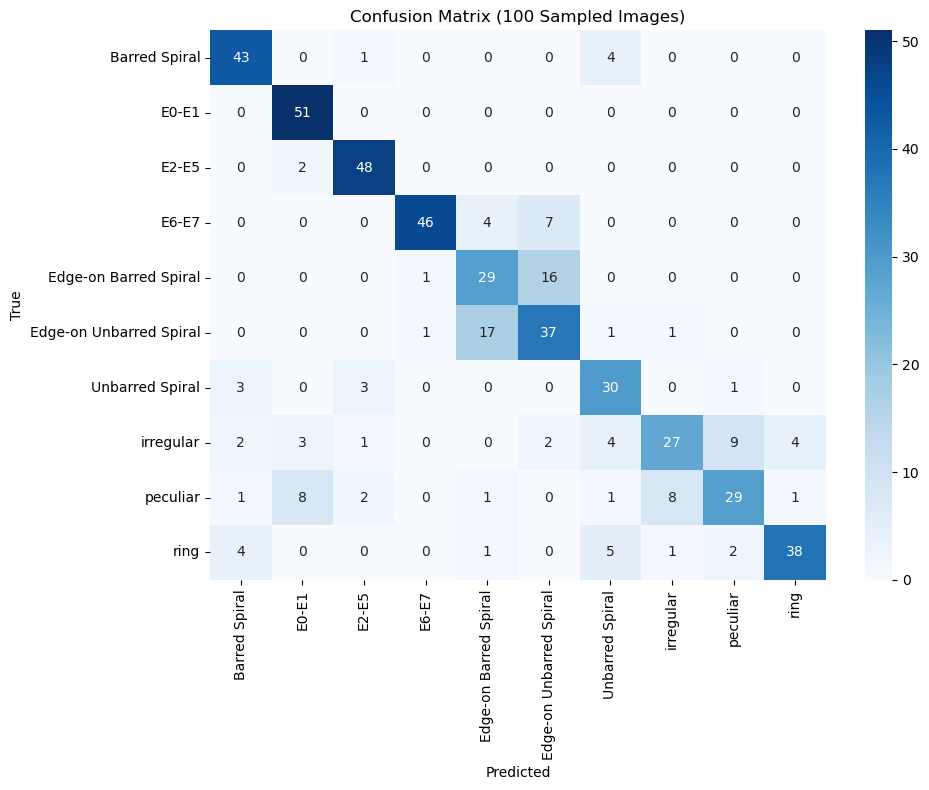

In [5]:
# === 4. Metrics ===
print("\n📊 Evaluation Metrics (500 images):")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='weighted'):.4f}")

print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# === 5. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (100 Sampled Images)")
plt.tight_layout()
plt.show()

In [58]:
import os
import numpy as np
from PIL import Image, ImageOps
import cv2

def preprocess_single_image(image_path, output_folder='C:\\Users\\grace\\Desktop\\DIP PROJECT\\test', size=224):
    os.makedirs(output_folder, exist_ok=True)

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    try:
        # Load and convert to RGB
        img = Image.open(image_path).convert('RGB')

        # Histogram normalization using OpenCV
        img_np = np.array(img)
        img_np = cv2.normalize(img_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img = Image.fromarray(img_np)

        # Resize and crop
        img = ImageOps.fit(img, (size, size), method=Image.LANCZOS, centering=(0.5, 0.5))

        # Save the processed image
        filename = os.path.basename("test.jpg")
        save_path = os.path.join(output_folder, filename)
        img.save(save_path)
        print(f"Processed image saved at: {save_path}")

        # Normalize to [-1, 1] range
        img_array = np.array(img) / 255.0
        img_array = (img_array - 0.5) / 0.5

        return img_array

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [59]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os

def predict_single_image_class(model_path, image_path, label_encoder, target_size=(224, 224)):
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess image exactly like training
    try:
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # SAME normalization as training
        img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
    except Exception as e:
        print(f"Failed to process image: {e}")
        return None

    # Predict
    preds = model.predict(img_array)
    predicted_index = np.argmax(preds, axis=1)[0]
    predicted_class = label_encoder.inverse_transform([predicted_index])[0]

    print(f"[DEBUG] Prediction Vector: {preds}")
    print(f"Predicted: {predicted_class}")
    return predicted_class


In [1]:
import tensorflow as tf

# Load the model
model_path = 'separable_cnn_improved_75acc.keras'
model = tf.keras.models.load_model(model_path)

# Output the model summary
model.summary()


c:\Users\grace\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_1              │ (None, 222, 222, 64)   │           283 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 220, 220, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 108, 108, 128)  │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 106, 106, 128)  │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 51, 51, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 49, 49, 256)    │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 409,804 (1.56 MB)

 Trainable params: 204,005 (796.89 KB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 204,007 (796.91 KB)

In [62]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv("C:\\Users\\grace\\Desktop\\DIP PROJECT\\merged_classes.csv")
le = LabelEncoder()
le.fit(df['class'])
processed_image = preprocess_single_image("C:\\Users\\grace\\Desktop\\DIP PROJECT\\dip\\9.jpg")
image_path = "C:\\Users\\grace\\Desktop\\DIP PROJECT\\test\\test.jpg"
model_path = "C:\\Users\\grace\\Desktop\\DIP PROJECT\\separable_cnn_improved_75acc.keras"

predicted_class = predict_single_image_class(model_path, image_path, le)
print("Class =", predicted_class)


Processed image saved at: C:\Users\grace\Desktop\DIP PROJECT\test\test.jpg


c:\Users\grace\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 36 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[DEBUG] Prediction Vector: [[8.9390967e-03 1.4057133e-05 2.7957332e-05 1.5786577e-08 1.7431317e-07
  1.9749698e-06 9.8799324e-01 5.0096924e-04 5.6279765e-05 2.4663194e-03]]
Predicted: Unbarred Spiral
Class = Unbarred Spiral
